# Loan Default Prediction

---

## 1. Environment Prepration

In [155]:
import numpy as np
import pandas as pd
import mlflow

In [156]:
# Set environment variables
data_path = "Data/Processed_Loan_Data.csv"
models_path = "Models/"
random_seed = 42  # Set the random seed for reproducibility

### MlFlow Setup

In [157]:
# Start local MLflow server
# Run this in a terminal
# mlflow server --host 127.0.0.1 --port 8080

In [158]:
# Cnnect to the MLflow tracking server
try:
    mlflow.set_tracking_uri("http://127.0.0.1:8080")
    client = mlflow.MlflowClient(tracking_uri="http://127.0.0.1:8080")
    print("Connected to MLflow server")
except:
    print(
        "MLflow server is not running!\nPlease execute the cell above in a terminal to launch the MLflow server."
    )

Connected to MLflow server


---

## 2. Data Preprocessing

In [159]:
df = pd.read_csv(data_path)
df.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,0,0.747058,-0.724812,0.398535,0.285411,-0.536743,False
1,5,-1.548297,-0.073963,-2.161768,-1.629243,-1.080777,True
2,0,-0.560481,-1.009645,-0.207909,-0.352807,-0.586201,False
3,0,0.427024,-0.938137,0.215073,0.285411,-0.421342,False
4,1,-1.979634,-1.048728,-2.321198,0.923629,-0.108110,False


In [160]:
# Split the data into features and target
X = df.drop("default", axis=1)
y = df["default"]
X.shape, y.shape

((10000, 6), (10000,))

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_seed
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

---

## 3. Model Experimentation

### A. Logistic Regression

In [162]:
# Set the experiment name
experiment_tags = {"project_name":"Loan Default Prediction" ,"data": "Loan Data","team":"Kallel-Rigoni-Rodner", "model": "Logistic Regression"}
logistic_regression_experiment = client.create_experiment(name="Logistic_Regression",tags=experiment_tags)

In [163]:
mlflow.set_experiment("Logistic_Regression")

<Experiment: artifact_location='mlflow-artifacts:/212771965211801295', creation_time=1725676705720, experiment_id='212771965211801295', last_update_time=1725676705720, lifecycle_stage='active', name='Logistic_Regression', tags={'data': 'Loan Data',
 'model': 'Logistic Regression',
 'project_name': 'Loan Default Prediction',
 'team': 'Kallel-Rigoni-Rodner'}>

In [183]:
def train_eval_logistic_regression(X_train, y_train, X_test, y_test, params, run_name):
    """
    Train and evaluate a Logistic Regression model.

    Parameters:
    X_train (array-like): Training feature data.
    y_train (array-like): Training target data.
    X_test (array-like): Testing feature data.
    y_test (array-like): Testing target data.
    params (dict): Parameters for the Logistic Regression model.
    run_name (str): Name for the MLflow run.

    Returns:
    dict: A dictionary containing evaluation metrics.
    matplotlib.figure.Figure: The confusion matrix figure.
    """
    
    # Create a Logistic Regression model with the given parameters
    model = LogisticRegression(**params)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Generate a classification report and confusion matrix
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Extract confusion matrix values
    tn, fp, fn, tp = conf_matrix.ravel().astype(int)
    
    # Extract evaluation metrics for the 'default' and 'no_default' classes
    default_precision, default_recall, default_f1_score, _ = class_report["True"].values()
    no_default_precision, no_default_recall, no_default_f1_score, _ = class_report["False"].values()
    
    # Create and display the confusion matrix
    fig, ax = plt.subplots(figsize=(7, 6))
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["no_default", "default"])
    cm_display.plot(ax=ax, cmap="Blues")  # Use the 'Blues' colormap for blue colors
    ax.set_title("Confusion Matrix")  # Add a title
    
    # Compile evaluation metrics into a dictionary
    metrics = {
        "default_precision": default_precision,
        "default_recall": default_recall,
        "default_f1_score": default_f1_score,
        "no_default_precision": no_default_precision,
        "no_default_recall": no_default_recall,
        "no_default_f1_score": no_default_f1_score,
        "false_positives": int(fp),
        "false_negatives": int(fn),
    }
    metrics = {k:round(v,2) for k,v in metrics.items()}
    
    # Log the model and metrics in MLflow
    with mlflow.start_run(run_name=run_name) as run:
        mlflow.log_params(params)  # Log model parameters
        mlflow.log_metrics(metrics)  # Log evaluation metrics
        mlflow.log_figure(fig, "confusion_matrix.png")  # Log confusion matrix figure
        mlflow.sklearn.log_model(sk_model=model, input_example=X_test, artifact_path=run_name)  # Log the model
    
    return metrics, fig

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define the model parameters
run_name="Logistic_regression_balanced_saga_elasticnet"
model_params = {
    "fit_intercept":True,
    "class_weight":'balanced',
    "penalty":'elasticnet',
    "solver":"saga",
    "l1_ratio":0.5,
    "max_iter":1000,
    "random_state":random_seed,
}

class_report,conf_matrix = train_eval_logistic_regression(X_train, y_train, X_test, y_test,model_params,run_name)

class_report

/mnt/77165487061AF296/Sorbonne_Data_Analytics_SDA/Cours/ML-OPS_Kamila.Kare/Projet_ML_Ops/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2024/09/07 03:53:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic_regression_balanced_saga_elasticnet at: http://127.0.0.1:8080/#/experiments/2

{'default_precision': 0.98,
 'default_recall': 1.0,
 'default_f1_score': 0.99,
 'no_default_precision': 1.0,
 'no_default_recall': 1.0,
 'no_default_f1_score': 1.0,
 'false_positives': 6,
 'false_negatives': 1}

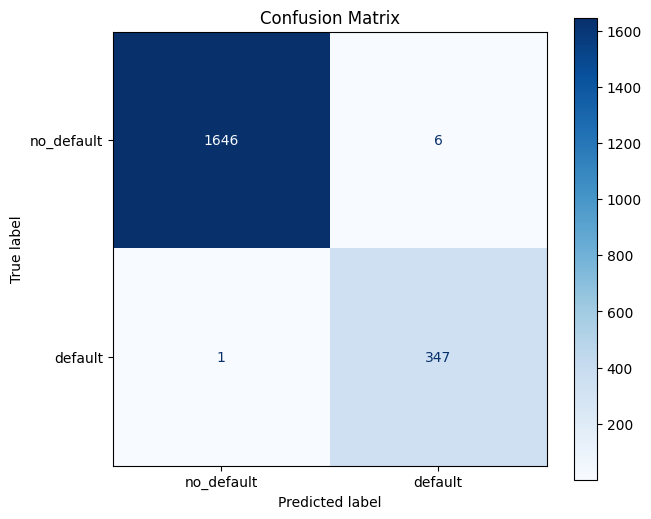

In [192]:
conf_matrix